# Key Assumption

The volatility between price show how the market feels - and might help us guess what happens next and do a decision.

#  Sub-Assumption

1. If a candle has a much bigger range than usual, it might mean a breakout or trend is starting.
2. If a market is moving a lot today, it will probably keep moving a lot tomorrow too.
3. if the shadows are large compared to the full candle, it means the market is unsure - price was pushed away from the highs/lows. That could mean a potential reversal.


# Hypothesis

Volatility patterns from candlestick data (range, continuation, and shadow size) reflect market behaviour, and can be used to anticipate breakouts, continuations, or reversals.

# Formula Calculation

SignalScore = w1 * RangeVol + w2 * VolCluster - w3 * WickRatio

where;

    - RangeVol = High - Low
    - VolCluster = VolCluster = std(Close - N:t)
    - WickRatio = (High - max(open,close) + min(open,close) - low) / (high - low + e)

# Load Data, Check Data whether is null or not

In [3]:
!pip install cybotrade_datasource
!pip install python-dotenv
!pip install hmmlearn

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')

'''
async def main():
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic='cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour', 
        start_time=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
        end_time=datetime(year=2025, month=1, day=1, tzinfo=timezone.utc)
    )
    df = pd.DataFrame(data)
    print(df)
    

await main()
'''

'''
async def main():
    stream = await cybotrade_datasource.stream(
        api_key=API_KEY,
        topics=[
            'cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour',
            'cryptoquant|btc/market-data/liquidations?exchange=deribit&window=min',
        ],
    )
    async for msg in stream:
        print(msg)
    

await main()
'''

global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743860100000  82738.1  82804.7  82738.0  82796.2   56.009
1     1743860160000  82720.0  82745.0  82710.0  82738.1   57.188
2     1743860220000  82703.1  82762.8  82703.0  82720.0  133.710
3     1743860280000  82700.5  82725.9  82692.4  82703.1   37.703
4     1743860340000  82734.8  82747.1  82690.1  82700.5   39.877
...             ...      ...      ...      ...      ...      ...
9995  1744459800000  83547.2  83560.0  83532.8  83552.2   30.189
9996  1744459860000  83558.5  83562.0  83541.4  83547.2    8.373
9997  1744459920000  83600.8  83600.8  83558.4  83558.5   50.641
9998  1744459980000  83607.8  83607.8  83578.4  83600.8   33.155
9999  1744460

Display first five column of the dataframe

In [4]:
print(global_df)

         start_time    close     high      low     open   volume
0     1743860100000  82738.1  82804.7  82738.0  82796.2   56.009
1     1743860160000  82720.0  82745.0  82710.0  82738.1   57.188
2     1743860220000  82703.1  82762.8  82703.0  82720.0  133.710
3     1743860280000  82700.5  82725.9  82692.4  82703.1   37.703
4     1743860340000  82734.8  82747.1  82690.1  82700.5   39.877
...             ...      ...      ...      ...      ...      ...
9995  1744459800000  83547.2  83560.0  83532.8  83552.2   30.189
9996  1744459860000  83558.5  83562.0  83541.4  83547.2    8.373
9997  1744459920000  83600.8  83600.8  83558.4  83558.5   50.641
9998  1744459980000  83607.8  83607.8  83578.4  83600.8   33.155
9999  1744460040000  83630.0  83647.9  83607.8  83607.8   81.404

[10000 rows x 6 columns]


Analyze Data (first five and last five)

In [5]:
global_df.head()

,start_time,close,high,low,open,volume
0,1743860100000,82738.1,82804.7,82738.0,82796.2,56.009
1,1743860160000,82720.0,82745.0,82710.0,82738.1,57.188
2,1743860220000,82703.1,82762.8,82703.0,82720.0,133.710
3,1743860280000,82700.5,82725.9,82692.4,82703.1,37.703
4,1743860340000,82734.8,82747.1,82690.1,82700.5,39.877


In [6]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,1744459800000,83547.2,83560.0,83532.8,83552.2,30.189
9996,1744459860000,83558.5,83562.0,83541.4,83547.2,8.373
9997,1744459920000,83600.8,83600.8,83558.4,83558.5,50.641
9998,1744459980000,83607.8,83607.8,83578.4,83600.8,33.155
9999,1744460040000,83630.0,83647.9,83607.8,83607.8,81.404


In [7]:
global_df.shape

(10000, 6)

In [8]:
num_rows = len(global_df)
print(num_rows)

10000


We had 10000 rows in this dataset (latest)

In [9]:
cat_cols = global_df.select_dtypes(include=['object']).columns
num_cols = global_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index([], dtype='object')
Numerical Variables:
['start_time', 'close', 'high', 'low', 'open', 'volume']


In [10]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_time  10000 non-null  int64  
 1   close       10000 non-null  float64
 2   high        10000 non-null  float64
 3   low         10000 non-null  float64
 4   open        10000 non-null  float64
 5   volume      10000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 468.9 KB


Obtain a statistical summary of the dataframe using describe

In [11]:
global_df.describe()

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.744160e+12,80395.929450,80444.860570,80348.12474,80395.846070,116.372846
std,1.732137e+08,2496.748484,2479.195192,2513.67868,2496.654391,206.408674
min,1.743860e+12,74584.200000,74702.500000,74456.20000,74584.200000,0.946000
25%,1.744010e+12,78393.050000,78466.475000,78304.55000,78393.050000,27.887000
50%,1.744160e+12,80583.000000,80632.500000,80537.70000,80583.000000,59.174000
75%,1.744310e+12,82774.275000,82800.000000,82750.20000,82774.275000,124.009750
max,1.744460e+12,84239.500000,84288.000000,84100.00000,84239.500000,4595.508000


In [12]:
global_df.describe(include='all')

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.744160e+12,80395.929450,80444.860570,80348.12474,80395.846070,116.372846
std,1.732137e+08,2496.748484,2479.195192,2513.67868,2496.654391,206.408674
min,1.743860e+12,74584.200000,74702.500000,74456.20000,74584.200000,0.946000
25%,1.744010e+12,78393.050000,78466.475000,78304.55000,78393.050000,27.887000
50%,1.744160e+12,80583.000000,80632.500000,80537.70000,80583.000000,59.174000
75%,1.744310e+12,82774.275000,82800.000000,82750.20000,82774.275000,124.009750
max,1.744460e+12,84239.500000,84288.000000,84100.00000,84239.500000,4595.508000


In [13]:
num_rows = global_df.shape[0]
num_cols = global_df.shape[1]
print("Rows: ", num_rows, "Columns: ", num_cols)


Rows:  10000 Columns:  6


Show columns's data types using the property df.dtypes

In [14]:
global_df.dtypes

start_time      int64
close         float64
high          float64
low           float64
open          float64
volume        float64
dtype: object

In [15]:
summary_stats = global_df.describe()
print(summary_stats)

         start_time         close          high          low          open  \
count  1.000000e+04  10000.000000  10000.000000  10000.00000  10000.000000   
mean   1.744160e+12  80395.929450  80444.860570  80348.12474  80395.846070   
std    1.732137e+08   2496.748484   2479.195192   2513.67868   2496.654391   
min    1.743860e+12  74584.200000  74702.500000  74456.20000  74584.200000   
25%    1.744010e+12  78393.050000  78466.475000  78304.55000  78393.050000   
50%    1.744160e+12  80583.000000  80632.500000  80537.70000  80583.000000   
75%    1.744310e+12  82774.275000  82800.000000  82750.20000  82774.275000   
max    1.744460e+12  84239.500000  84288.000000  84100.00000  84239.500000   

             volume  
count  10000.000000  
mean     116.372846  
std      206.408674  
min        0.946000  
25%       27.887000  
50%       59.174000  
75%      124.009750  
max     4595.508000  


# Data Cleaning


In [16]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-05 13:35:00
1    2025-04-05 13:36:00
2    2025-04-05 13:37:00
3    2025-04-05 13:38:00
4    2025-04-05 13:39:00
...                  ...
9995 2025-04-12 12:10:00
9996 2025-04-12 12:11:00
9997 2025-04-12 12:12:00
9998 2025-04-12 12:13:00
9999 2025-04-12 12:14:00

[10000 rows x 1 columns]


In [17]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-05 13:35:00,82738.1,82804.7,82738.0,82796.2,56.009
1,2025-04-05 13:36:00,82720.0,82745.0,82710.0,82738.1,57.188
2,2025-04-05 13:37:00,82703.1,82762.8,82703.0,82720.0,133.710
3,2025-04-05 13:38:00,82700.5,82725.9,82692.4,82703.1,37.703
4,2025-04-05 13:39:00,82734.8,82747.1,82690.1,82700.5,39.877


In [18]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,2025-04-12 12:10:00,83547.2,83560.0,83532.8,83552.2,30.189
9996,2025-04-12 12:11:00,83558.5,83562.0,83541.4,83547.2,8.373
9997,2025-04-12 12:12:00,83600.8,83600.8,83558.4,83558.5,50.641
9998,2025-04-12 12:13:00,83607.8,83607.8,83578.4,83600.8,33.155
9999,2025-04-12 12:14:00,83630.0,83647.9,83607.8,83607.8,81.404


In [19]:
print(global_df)

              start_time    close     high      low     open   volume
0    2025-04-05 13:35:00  82738.1  82804.7  82738.0  82796.2   56.009
1    2025-04-05 13:36:00  82720.0  82745.0  82710.0  82738.1   57.188
2    2025-04-05 13:37:00  82703.1  82762.8  82703.0  82720.0  133.710
3    2025-04-05 13:38:00  82700.5  82725.9  82692.4  82703.1   37.703
4    2025-04-05 13:39:00  82734.8  82747.1  82690.1  82700.5   39.877
...                  ...      ...      ...      ...      ...      ...
9995 2025-04-12 12:10:00  83547.2  83560.0  83532.8  83552.2   30.189
9996 2025-04-12 12:11:00  83558.5  83562.0  83541.4  83547.2    8.373
9997 2025-04-12 12:12:00  83600.8  83600.8  83558.4  83558.5   50.641
9998 2025-04-12 12:13:00  83607.8  83607.8  83578.4  83600.8   33.155
9999 2025-04-12 12:14:00  83630.0  83647.9  83607.8  83607.8   81.404

[10000 rows x 6 columns]


In [20]:
global_df.dtypes

start_time    datetime64[ns]
close                float64
high                 float64
low                  float64
open                 float64
volume               float64
dtype: object

In [21]:
global_df.isnull().sum()

start_time    0
close         0
high          0
low           0
open          0
volume        0
dtype: int64

Percentage of missing value

In [22]:
(global_df.isnull().sum()/(len(global_df)))*100

start_time    0.0
close         0.0
high          0.0
low           0.0
open          0.0
volume        0.0
dtype: float64

Check duplicate value

In [23]:
global_df.count()

start_time    10000
close         10000
high          10000
low           10000
open          10000
volume        10000
dtype: int64

In [24]:
global_df.nunique()

start_time    10000
close          9031
high           8611
low            8657
open           9032
volume         9746
dtype: int64

In [25]:
duplicate_rows = global_df.duplicated()

# Display rows with duplicates
duplicate_rows_df = global_df[duplicate_rows]
print(duplicate_rows_df)

Empty DataFrame
Columns: [start_time, close, high, low, open, volume]
Index: []


In [26]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-05 13:35:00,82738.1,82804.7,82738.0,82796.2,56.009
1,2025-04-05 13:36:00,82720.0,82745.0,82710.0,82738.1,57.188
2,2025-04-05 13:37:00,82703.1,82762.8,82703.0,82720.0,133.710
3,2025-04-05 13:38:00,82700.5,82725.9,82692.4,82703.1,37.703
4,2025-04-05 13:39:00,82734.8,82747.1,82690.1,82700.5,39.877


Exploratory Data Analysis

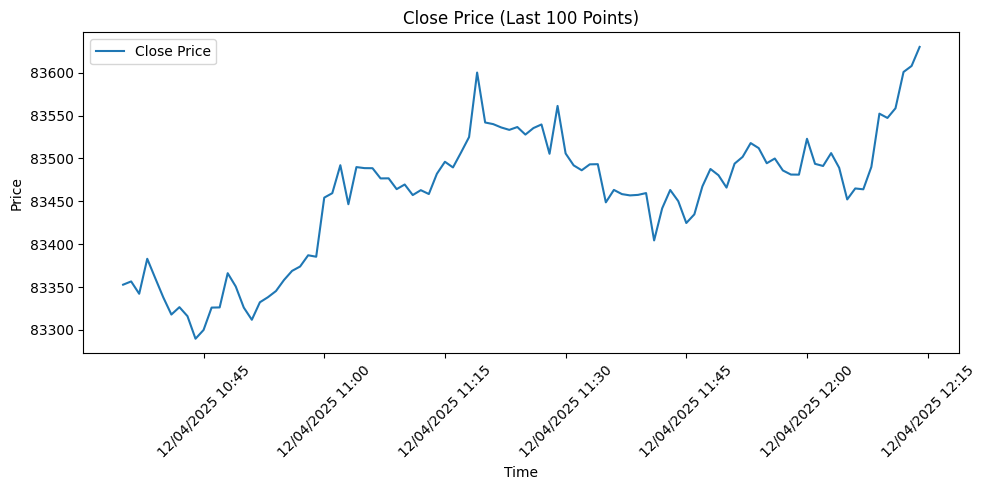

In [27]:
from matplotlib.dates import DateFormatter

# Convert your time column
global_df['start_time'] = pd.to_datetime(global_df['start_time'])

# Get last 100 rows
df_last = global_df.tail(100)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_last['start_time'], df_last['close'], label='Close Price')

# Set custom date format
date_fmt = DateFormatter('%d/%m/%Y %H:%M')  # Example: 10/04/2025 07:45
ax.xaxis.set_major_formatter(date_fmt)

# Labeling
ax.set_title('Close Price (Last 100 Points)')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Uptrend (approx. 09:25–09:45): The price shows a gradual and consistent increase, suggesting positive market sentiment or buying pressure.

Volatility Phase (approx. 09:45–10:00): Sharp up and down fluctuations in close price. This often suggests indecision, possible news events, or liquidity imbalances.

Downtrend (approx. 10:00–10:30): Clear and sharp drop in price.
May signal profit-taking, bearish sentiment, or reversal of earlier gains.

Mild Recovery (approx. 10:30–11:00): After hitting a low, price slightly rises again. Indicates attempt to regain confidence, but still uncertain.

# Model Prediction & Backtest - Volatility

In [28]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-05 13:35:00
1    2025-04-05 13:36:00
2    2025-04-05 13:37:00
3    2025-04-05 13:38:00
4    2025-04-05 13:39:00
...                  ...
9995 2025-04-12 12:10:00
9996 2025-04-12 12:11:00
9997 2025-04-12 12:12:00
9998 2025-04-12 12:13:00
9999 2025-04-12 12:14:00

[10000 rows x 1 columns]


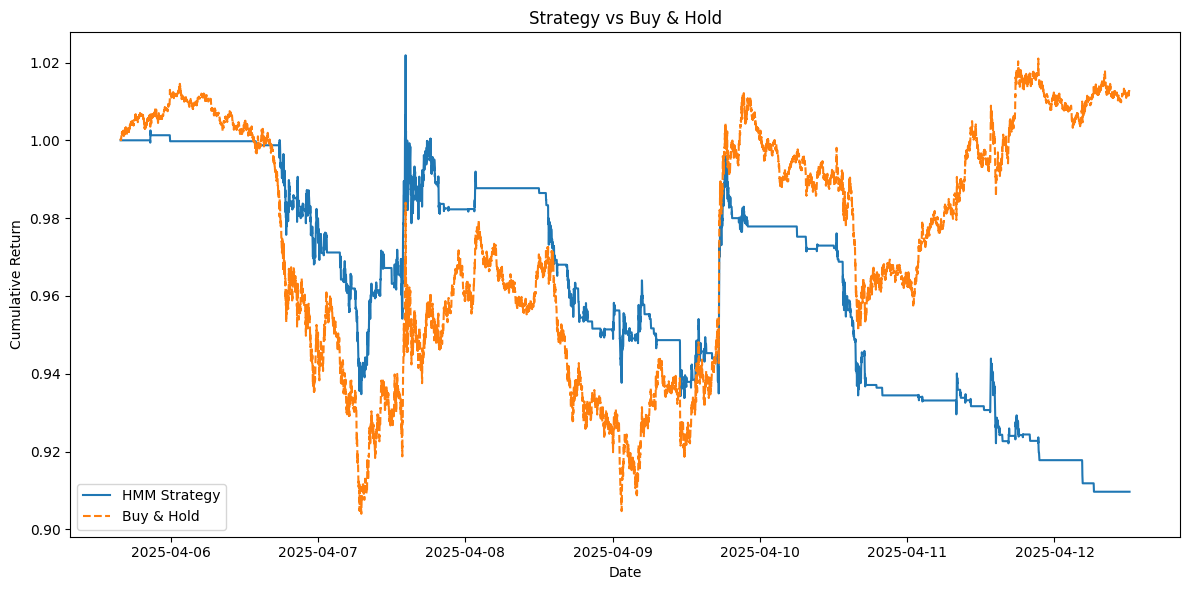

Sharpe Ratio: -0.17
Total Return: -9.03%
Max Drawdown: -10.98%
Trade Frequency: 2.95%


In [43]:
global_df['RangeVol'] = global_df['high'] - global_df['low']
global_df['VolCluster'] = global_df['close'].rolling(window=10).std()
epsilon = 1e-6
global_df['upper_wick'] = global_df['high'] - global_df[['open', 'close']].max(axis=1)
global_df['lower_wick'] = global_df[['open', 'close']].min(axis=1) - global_df['low']
global_df['wick_ratio'] = (global_df['upper_wick'] + global_df['lower_wick']) / (global_df['high'] - global_df['low'] + epsilon)

#improvement 
global_df['log_return'] = np.log(global_df['close'] / global_df['close'].shift(1))
global_df['realized_vol'] = global_df['log_return'].rolling(window=10).std() * np.sqrt(252)
global_df['range_pct'] = (global_df['high'] - global_df['low']) / global_df['low']


global_df = global_df.dropna(subset=['VolCluster']).reset_index(drop=True)


scaler = StandardScaler()
global_df[['RangeVol', 'VolCluster', 'wick_ratio', 'log_return', 'realized_vol', 'range_pct']] = scaler.fit_transform(
    global_df[['RangeVol', 'VolCluster', 'wick_ratio', 'log_return', 'realized_vol', 'range_pct']]
)

# Drop rows with NaN values in specific columns
global_df.dropna(subset=[
    'RangeVol', 'VolCluster', 'wick_ratio',
    'log_return', 'realized_vol', 'range_pct'
], inplace=True)

global_df.reset_index(drop=True, inplace=True)

# hmm model 
X = global_df[['RangeVol', 'VolCluster', 'wick_ratio', 'log_return', 'realized_vol', 'range_pct']].values
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=200, random_state=42)
model.fit(X)
global_df['state'] = model.predict(X)

# Signal
global_df['return'] = global_df['close'].pct_change()
returns_by_state = global_df.groupby('state')['return'].mean()
good_state = returns_by_state.idxmax()


global_df['signal'] = np.where(global_df['state'] == good_state, 1, 0)

# backtest
global_df['strategy_return'] = global_df['signal'].shift(1) * global_df['return']
fee = 0.0006
global_df['trade_occurred'] = global_df['signal'].diff().fillna(0) != 0
global_df['strategy_return_net'] = np.where(
    global_df['trade_occurred'], global_df['strategy_return'] - fee, global_df['strategy_return']
)


cumulative = (1 + global_df['strategy_return_net'].fillna(0)).cumprod()
buy_hold = (1 + global_df['return'].fillna(0)).cumprod()
sharpe = global_df['strategy_return_net'].mean() / global_df['strategy_return_net'].std() * np.sqrt(252)
cumulative_return = cumulative.iloc[-1] - 1
drawdown = cumulative / cumulative.cummax() - 1
max_dd = drawdown.min()
trade_freq = (global_df['signal'].diff() != 0).sum() / len(global_df)

# === Plot ===
plt.figure(figsize=(12, 6))
plt.plot(global_df['start_time'], cumulative, label='HMM Strategy')
plt.plot(global_df['start_time'], buy_hold, label='Buy & Hold', linestyle='--')
plt.title("Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

# === Print Metrics ===
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Total Return: {cumulative_return:.2%}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Trade Frequency: {trade_freq:.2%}")
